In [1]:
!pip install datasets[vision] tensorflow opencv-python-headless matplotlib scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for datasets[vision] from https://files.pythonhosted.org/packages/09/7e/fd4d6441a541dba61d0acb3c1fd5df53214c2e9033854e837a99dd9e0793/datasets-2.14.5-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b5/24/aaccf324ce862bb82277e8814d2aebbb2a2c160d04e95aa2b8c9dc3137a9/matplotlib-3.8.0-cp310-cp310-m

In [2]:
#import cv2
import datasets
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import mean_squared_error

# custom models
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2DTranspose, Activation
from tensorflow.keras.models import Sequential, Model

# vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

/home/ucloud/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-29 10:04:01.409003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 10:04:01.448467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-29 10:04:01.448500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-29 10:04:01.448525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 

In [3]:
###
### data
###

wikiart = datasets.load_dataset("huggan/wikiart", split='train', streaming=True).take(5000)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

ds = datasets.Dataset.from_generator(partial(gen_from_iterable_dataset, wikiart), features=wikiart.features)

Resolving data files: 100%|██████████| 72/72 [00:27<00:00,  2.65it/s]
Generating train split: 5000 examples [02:45, 30.17 examples/s]


In [4]:
###
### preprocess
###

def _preprocess_image(example):
  # resize to VGG input size
  X = example['image']
  X = X.resize((224, 224))
  X = image.img_to_array(X)
  X = np.expand_dims(X, axis=0)
  X = preprocess_input(X)
  example['image'] = X
  return example


ds_prep = (ds
      .map(_preprocess_image)
)                                      
           
original_images = ds_prep.with_format('np', columns=['image'], output_all_columns=False)['image']
original_image = np.array(ds_prep[0]['image'])

ds_prep_tf = ds_prep.to_tf_dataset(
            columns=["image"],
            # label_cols=["image"],
            )

Map: 100%|██████████| 5000/5000 [07:45<00:00, 10.74 examples/s]   
/home/ucloud/.local/lib/python3.10/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [5]:
###
### encoder VGG16
###

# Load the VGG16 model with pre-trained weights (excluding the top classification layers)
vgg16 = VGG16(weights='imagenet', include_top=False)

# Encode the image using the VGG16 model
encoded_features = vgg16.predict(original_image)
encoded_dataset = vgg16.predict(ds_prep_tf)

# Print the shape of the encoded features
print("Shape of encoded features:", encoded_features.shape)
print("Shape of encoded dataset:", encoded_dataset.shape)

5000/5000 [==============================] - 1403s 281ms/step
Shape of encoded features: (1, 7, 7, 512)
Shape of encoded dataset: (5000, 7, 7, 512)


In [34]:
###
### decoder VGG16
###

# Define the input for the decoder
encoded_input = Input(shape=(7, 7, 512))  # Shape matches the output shape of VGG16's encoder

# Add transpose convolutional layers to upsample the encoded features
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(encoded_input)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(3, (3, 3), strides=(4, 4), padding='same', activation='sigmoid')(x)  # Output layer, using sigmoid activation for pixel values

# Create the decoder model
decoder = Model(inputs=encoded_input, outputs=x)

# Print a summary of the decoder model
decoder.summary()

# yeah
decoder.compile(loss='mean_squared_error', optimizer='adam')
decoder.fit(encoded_dataset, original_images, epochs=10)

# Reconstruct the original image
reconstructed_image_og = decoder.predict(encoded_features)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 conv2d_transpose_16 (Conv2  (None, 14, 14, 256)       1179904   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_17 (Conv2  (None, 28, 28, 128)       295040    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_18 (Conv2  (None, 56, 56, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_19 (Conv2  (None, 224, 224, 3)       1731      
 DTranspose)                                               

In [7]:
###
### errror
###

original_image_flat = original_image.flatten()
reconstructed_image_flat = reconstructed_image.flatten()

# Calculate the Mean Squared Error
mse = mean_squared_error(original_image_flat, reconstructed_image_flat)

# Print the MSE
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 3256.7787021208806


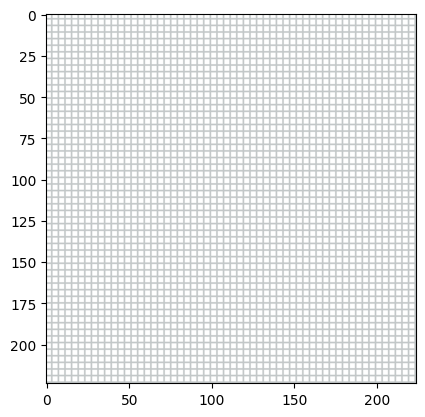

In [8]:
plt.imshow(np.squeeze(reconstructed_image, axis=0))

In [39]:
np.amin(reconstructed_image_og)

0.76212496

In [40]:
np.amax(reconstructed_image_og)

1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


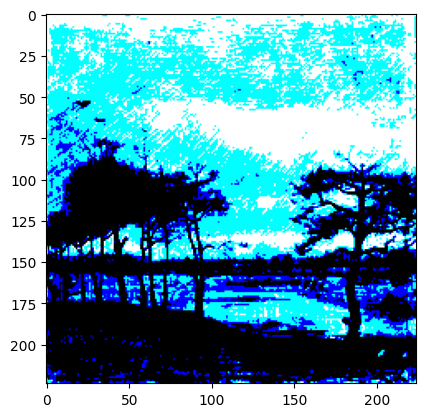

In [9]:
plt.imshow(np.squeeze(original_image, axis=0))

In [16]:
#### 

### trying to standardize differently

###

def _preprocess_image_std(example):
  # resize to VGG input size
  X = example['image']
  X = X.resize((224, 224))
  X = image.img_to_array(X)
  X = np.expand_dims(X, axis=0)
  X = X.astype('float32') / 255.0
  example['image'] = X
  return example


ds_prep_std = (ds
      .map(_preprocess_image_std)
)                                      
           
original_images_std = ds_prep_std.with_format('np', columns=['image'], output_all_columns=False)['image']
original_image_std = np.array(ds_prep_std[0]['image'])

ds_prep_std_tf = ds_prep_std.to_tf_dataset(
            columns=["image"],
            # label_cols=["image"],
            )

Map: 100%|██████████| 5000/5000 [07:34<00:00, 11.00 examples/s]   
/home/ucloud/.local/lib/python3.10/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [17]:
###
### encoder VGG16
###

# Load the VGG16 model with pre-trained weights (excluding the top classification layers)
vgg16 = VGG16(weights='imagenet', include_top=False)

# Encode the image using the VGG16 model
encoded_features_std = vgg16.predict(original_image_std)
encoded_dataset_std = vgg16.predict(ds_prep_std_tf)

# Print the shape of the encoded features
print("Shape of encoded features:", encoded_features_std.shape)
print("Shape of encoded dataset:", encoded_dataset_std.shape)

5000/5000 [==============================] - 1406s 281ms/step
Shape of encoded features: (1, 7, 7, 512)
Shape of encoded dataset: (5000, 7, 7, 512)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 14, 14, 256)       1179904   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 28, 28, 128)       295040    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_14 (Conv2  (None, 56, 56, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_15 (Conv2  (None, 224, 224, 3)       1731      
 DTranspose)                                               

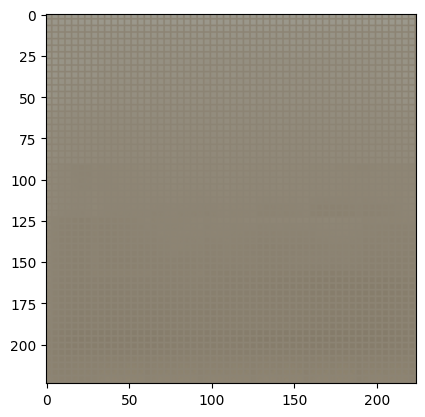

In [20]:
###
### decoder VGG16
###

# Define the input for the decoder
encoded_input = Input(shape=(7, 7, 512))  # Shape matches the output shape of VGG16's encoder

# Add transpose convolutional layers to upsample the encoded features
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(encoded_input)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(3, (3, 3), strides=(4, 4), padding='same', activation='sigmoid')(x)  # Output layer, using sigmoid activation for pixel values

# Create the decoder model
decoder = Model(inputs=encoded_input, outputs=x)

# Print a summary of the decoder model
decoder.summary()

# yeah
decoder.compile(loss='mean_squared_error', optimizer='adam')
decoder.fit(encoded_dataset_std, original_images_std, epochs=10)

# Reconstruct the original image
reconstructed_image = decoder.predict(encoded_features_std)

plt.imshow(np.squeeze(reconstructed_image, axis=0))

In [22]:
np.amin(reconstructed_image)

0.4121305

In [23]:
np.amax(reconstructed_image)

0.62428033

In [41]:
print(np.amin(original_image_std))
print(np.amax(original_image_std))

0.0
0.9176470637321472
